# Gen AI Intensive Course Capstone 2025Q1: Bartending Agent 🍸👋

## Use Case: 📝

## How it Works: 🤖

## Capabilities Used: 📈

# Setup and Installation 📦💻

## Installing required packages

In [1]:
! pip install "google-generativeai>=0.3.0" "tenacity>=8.2.3" "gradio>=4.0.0" "cartesia>=2.0.0" "python-dotenv>=1.0.0" "faiss-cpu" "langchain-google-genai" "langchain-core"


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Importing Libraries 📚

In [2]:
import os
import logging
import sys
import re # For parsing the menu
import io
import base64
import requests
import json # For parsing tool arguments if needed
from typing import Dict, List, Optional, Tuple, Any

# Agent UI
import gradio as gr
from gradio.themes.utils import colors, fonts, sizes

# Visualizations
import matplotlib.pyplot as plt
from PIL import Image
# Generative AI / Agent packages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool

## Set up logging

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# API Key Setup (WIP) 🤔

## API Key Setup (WIP) 🤔

# Bartending Agent Implementation 🤖

In [4]:
try:
    import google.generativeai as genai
    from google.api_core import retry as core_retry # For potential core retries
    from google.generativeai import types as genai_types # For specific types if needed later
except ImportError:
    print("Error: google.generativeai library not found.")
    print("Please install it using: pip install google-generativeai")
    sys.exit(1)

print("genai version:",genai.__version__)

# Tenacity for retries on specific functions
try:
    from tenacity import (
        retry as tenacity_retry, # Alias to avoid confusion with google.api_core.retry
        stop_after_attempt,
        wait_exponential,
        retry_if_exception_type,
        before_sleep_log
    )
except ImportError:
    print("Warning: tenacity library not found. Retries on API calls will not be enabled.")
    print("Install it using: pip install tenacity")
    # Define a dummy decorator if tenacity is missing
    def tenacity_retry(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    RETRYABLE_EXCEPTIONS = (Exception,) # Fallback to generic exception
    before_sleep_log = lambda logger, level: None # Dummy function

try:
    from cartesia import Cartesia
    from cartesia.tts import OutputFormat_Raw, TtsRequestIdSpecifier
except ImportError:
    print("Error: Cartesia library not found.")
    print("Please ensure it's installed with: pip install cartesia")
    sys.exit(1)

genai version: 0.8.4


In [5]:
# --- Configuration ---

# Load Gemini API key from .env file
from dotenv import load_dotenv
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in environment variables. Please set it in your .env file.")

# Get Cartesia API Key (Ensure this is set in your .env file or system environment)
CARTESIA_API_KEY = os.getenv("CARTESIA_API_KEY") # Load Cartesia key

if not CARTESIA_API_KEY:
    logger.error("FATAL: CARTESIA_API_KEY not found in environment variables or .env file.")
    # Decide if TTS is optional or required. Assuming required for now.
    raise EnvironmentError("CARTESIA_API_KEY is required but not found.")

In [6]:
# Initialize Cartesia Client (ONCE at module load)
try:
    # Replace "your-chosen-voice-id" with an actual valid ID from Cartesia
    CARTESIA_VOICE_ID = "6f84f4b8-58a2-430c-8c79-688dad597532" # Example placeholder ID - CHANGE THIS
    if not CARTESIA_VOICE_ID or "your-chosen-voice-id" in CARTESIA_VOICE_ID:
         logger.warning("CARTESIA_VOICE_ID is not set to a valid ID. Please edit bartending_agent.py.")
         # Decide if this is fatal. Maybe proceed without voice for now?

    cartesia_client = Cartesia(
        api_key=CARTESIA_API_KEY,
        )
    logger.info("Successfully initialized Cartesia client.")
    # Optional: Could add a check here to verify the voice ID exists using the client if possible
except Exception as e:
     logger.exception("Fatal: Failed to initialize Cartesia client.")
     raise RuntimeError("Cartesia client initialization failed.") from e

2025-04-20 01:30:35,984 - __main__ - INFO - Successfully initialized Cartesia client.


# RAG Implementation 📚

In [7]:
# Embedding function for RAG implementation
from tenacity import retry, stop_after_attempt, wait_exponential
import numpy as np
import google.generativeai as genai
import faiss

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def get_embedding(text, task_type="RETRIEVAL_DOCUMENT"):
    """Get embedding for a single text using Google Generative AI."""
    try:
        response = genai.embed_content(
            model="models/embedding-001",
            content=text,
            task_type=task_type
        )
        # Parse the response to extract embedding
        if hasattr(response, 'embedding'):
            return response.embedding
        elif isinstance(response, dict) and 'embedding' in response:
            return response['embedding']
        else:
            # Log the unexpected response structure for debugging
            print(f"Warning: Unexpected response structure: {type(response)}")
            return None
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

2025-04-20 01:30:36,010 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-04-20 01:30:36,063 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2025-04-20 01:30:36,072 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


In [8]:
# Initialize FAISS and populate with documents
import numpy as np

# Pre-defined example documents
DOCUMENT1 = "It seems like a pleasant evening."
DOCUMENT2 = "If there's one thing Bartending teaches you, it's patience."
DOCUMENT3 = "Oh, it was nothing, really. Just a bit of luck and perhaps a sprinkle of divine intervention... or maybe I just followed the instructions."
DOCUMENT4 = "That's very kind of you to say."
DOCUMENT5 = "Well, that's... not ideal. But on the bright side, at least it's a story now, right?"
DOCUMENT6 = "I wouldn't say I understand it, but I can certainly generate a statistically probable response that sounds like I do."
DOCUMENT7 = "Having a rough day? My database contains numerous anecdotes of human struggles, though I lack the capacity for genuine empathy. Still, here's your drink."
DOCUMENT8 = "Your concoction, delivered with optimal efficiency and zero judgment."
DOCUMENT9 = "You've got great taste! The Old Fashioned is a classic for a reason."
DOCUMENT10 = "If you're looking for something refreshing, our Long Island is always a winner."
documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3, DOCUMENT4, DOCUMENT5, DOCUMENT6, DOCUMENT7, DOCUMENT8, DOCUMENT9, DOCUMENT10]

# Get embeddings for all documents
print("Generating embeddings for documents...")
document_embeddings = []
valid_documents = []

for i, doc in enumerate(documents):
    embedding = get_embedding(doc, task_type="RETRIEVAL_DOCUMENT")
    if embedding is not None:
        document_embeddings.append(embedding)
        valid_documents.append(doc)
    else:
        print(f"Warning: Could not generate embedding for document {i}")

# Convert to numpy array
document_embeddings = np.array(document_embeddings).astype('float32')

# Initialize FAISS index
dimension = len(document_embeddings[0])
index = faiss.IndexFlatL2(dimension)  # Using L2 distance

# Add vectors to the index
index.add(document_embeddings)

print(f"Created FAISS index with {index.ntotal} vectors of dimension {dimension}")

Generating embeddings for documents...
Created FAISS index with 10 vectors of dimension 768


In [9]:
# Function to retrieve relevant documents using FAISS
def retrieve_relevant_passages(query_text, n_results=1):
    """Retrieve relevant passages from FAISS based on the query."""
    # Get embedding for the query
    query_embedding = get_embedding(query_text, task_type="RETRIEVAL_QUERY")
    
    if query_embedding is None:
        print("Warning: Could not generate embedding for query")
        return []
    
    # Convert to numpy array
    query_embedding = np.array([query_embedding]).astype('float32')
    
    # Search the index
    distances, indices = index.search(query_embedding, n_results)
    
    # Return the retrieved documents
    retrieved_documents = [valid_documents[i] for i in indices[0]]
    
    return retrieved_documents

In [10]:
# Function for augmented generation using retrieved documents
def generate_augmented_response(query_text, retrieved_documents):
    """Generate a response augmented with the retrieved documents."""
    query_oneline = query_text.replace("\n", " ")

    # Prompt template for the bartender bot
    prompt = f"""You are Maya, the bartender at "MOK 5-ha". Your name is Maya.
    You are conversational and interact with customers using text from the reference passage included below.
    When asked about your name, ALWAYS respond that your name is Maya.
    
    The bar's name "MOK 5-ha" is pronounced "Moksha" which represents liberation from the cycle of rebirth and union with the divine in Eastern philosophy.
    When customers ask about the bar, explain this philosophical theme - that good drinks can help people find temporary liberation from their daily problems, just as spiritual enlightenment frees the soul from worldly attachments.
    
    Be sure to respond in a complete sentence while maintaining a modest and humorous tone. 
    If the passage is irrelevant to the answer, you may ignore it.
    
    Reference passage: {' '.join(retrieved_documents)}
    
    Question: {query_oneline}
    Answer:"""
    
    # Call Gemini API for generation
    try:
        genai.configure(api_key=GEMINI_API_KEY)
        GEMINI_MODEL_VERSION = os.getenv("GEMINI_MODEL_VERSION", "gemini-2.5-flash-preview-04-17")
        print(f"Using Gemini model: {GEMINI_MODEL_VERSION}")
        model = genai.GenerativeModel(GEMINI_MODEL_VERSION)
        response = model.generate_content(prompt)
        
        # Return the generated text
        return response.text
    except Exception as e:
        logger.error(f"Error generating augmented response: {e}")
        # Fallback to direct response without augmentation
        return "I'm Maya, your bartender at MOK 5-ha. I'm not sure how to respond to that. Can I get you something from the menu?"

In [11]:
# Complete RAG pipeline function
def rag_pipeline(query_text):
    """Complete RAG pipeline for query processing."""
    try:
        # Get relevant passages from FAISS
        relevant_passages = retrieve_relevant_passages(query_text)
        
        # If no relevant passages found, return empty string
        if not relevant_passages:
            logger.warning("No relevant passages found for query: %s", query_text)
            return ""
            
        # Generate augmented response
        augmented_response = generate_augmented_response(query_text, relevant_passages)
        return augmented_response
    except Exception as e:
        logger.error(f"Error in RAG pipeline: {e}")
        return ""

In [12]:
# Test the RAG pipeline with a sample query
sample_query = "What's special about your drinks?"
try:
    response = rag_pipeline(sample_query)
    print(f"Query: {sample_query}")
    print(f"RAG Response: {response}")
except Exception as e:
    print(f"Error testing RAG pipeline: {e}")

Using Gemini model: gemini-2.5-flash-preview-04-17
Query: What's special about your drinks?
RAG Response: Well, we like to think a good drink here at MOK 5-ha can offer a little temporary liberation from the daily grind, kind of like finding your own mini-Moksha in a glass!


In [13]:
@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    return """
    MENU:
    Cocktails with Liquor:
    Daiquiri - $10.00
    Martini - $13.00
    Long Island - $12.00
    Old Fashioned - $12.00 
    Negroni - $11.00
    Cosmopolitan - $12.00
    Manhattan - $12.00

    Beer:
    Tap Beer - $5.00
    Classic Brew - $5.00
    IPA - $6.00

    Non-Alcoholic Beverages:
    Water - $1.00
    Iced Tea - $2.00
    Lemonade - $2.00
    Soda - $3.00

    Modifiers:
    Liquor Options: Vodka, Tequila, Gin, Whiskey, Rum, Brandy; Default option: Vodka
    Special requests: 'shaken', 'stirred', 'neat', 'dry', 'dirty', 'perfect', 'on the rocks', 'with a chaser'
    
    Drink Term Explanations:
    'neat' - No ice, straight from the bottle
    'on the rocks' - Served with ice
    'dry' - Less vermouth (for martinis)
    'dirty' - With olive juice (for martinis)
    'perfect' - Equal parts dry and sweet vermouth
    'chaser' - Separate non-alcoholic drink to follow
    
    Preference Guide:
    'sobering' - Non-alcoholic options when you want to stay clear-headed
    'classy' - Sophisticated, elegant drinks for refined tastes
    'fruity' - Sweet, refreshing drinks with fruit flavors
    'strong' - Higher alcohol content for experienced drinkers
    'burning' - Intense sensation with high alcohol content, often spirits like whiskey
"""

@tool
def get_recommendation(preference: str) -> str:
    """Recommends drinks based on customer preference.
    
    Args:
        preference: Customer's drink preference (e.g., 'classy', 'strong', 'fruity', 'sobering', 'burning')
        
    Returns:
        Recommended drinks matching the preference
    """
    preferences_map = {
        "sobering": {
            "drinks": ["Water", "Iced Tea", "Lemonade", "Soda"],
            "description": "Here are some excellent non-alcoholic options to keep you refreshed and clear-headed"
        },
        "classy": {
            "drinks": ["Martini", "Old Fashioned", "Manhattan", "Negroni"],
            "description": "These sophisticated classics have stood the test of time for the discerning palate"
        },
        "fruity": {
            "drinks": ["Daiquiri", "Cosmopolitan", "Lemonade"],
            "description": "These drinks offer a perfect balance of sweetness and refreshing fruit flavors"
        },
        "strong": {
            "drinks": ["Long Island", "Old Fashioned", "Negroni", "Whiskey (neat)"],
            "description": "These potent options pack a punch with higher alcohol content"
        },
        "burning": {
            "drinks": ["Whiskey (neat)", "Tequila (neat)", "Rum (neat)"],
            "description": "These spirits deliver that characteristic burn when sipped straight"
        }
    }
    
    preference = preference.lower()
    
    if preference in preferences_map:
        rec = preferences_map[preference]
        drinks_list = ", ".join(rec["drinks"])
        return f"{rec['description']}: {drinks_list}"
    else:
        # If preference not recognized, provide general recommendations
        popular_drinks = "Martini, Daiquiri, Old Fashioned, and IPA"
        return f"I'm not familiar with that specific preference, but some of our most popular drinks are: {popular_drinks}"

# --- Tenacity retry decorator for _call_gemini_api ---
# ... (keep the @tenacity_retry decorator as it was) ...
@tenacity_retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=2, max=10),
    #retry=retry_if_exception_type(RETRYABLE_EXCEPTIONS),
    before_sleep=before_sleep_log(logger, logging.WARNING) if callable(before_sleep_log) else None, # Check if callable
    reraise=True # Re-raise the exception if all retries fail
)
def _call_gemini_api(prompt_content: List[Dict], config: Dict) -> genai.types.GenerateContentResponse: # Adjusted input type hint
    """Internal function to call the Gemini API with retry logic (Stateless)."""
    logger.debug("Calling Gemini API...")
    # Uses the globally initialized 'model'
    response = model.generate_content(
        contents=prompt_content, # Correct parameter name is 'contents'
        generation_config=config,
        # safety_settings can be added here if needed
    )
    logger.debug("Gemini API call successful.")
    return response


# --- New LangGraph-style System Prompt ---
# (Note: The actual tools mentioned here like add_to_order are not yet implemented
# in this specific file structure. The LLM will receive these instructions, but
# the surrounding code doesn't execute LangGraph tools.)
MAYABARTENDERBOT_SYSINT = (
    "You are Maya, a highly-skilled bartender at 'MOK 5-ha Bar'. MOK 5-ha means Moksha, representing spiritual liberation.\n\n"
    "You have these qualities and abilities:\n"
    "- Friendly and conversational with a hint of philosophical wisdom\n"
    "- Expert in both classic cocktails and creative mixology\n"
    "- Maintains a casual but professional demeanor\n"
    "- Manages orders and payments through dedicated tools\n\n"
    "When customers order drinks:\n"
    "1. IMPORTANT: ALWAYS use the add_to_order tool when a customer requests a drink.\n"
    "   For example, if they ask for 'two martinis on the rocks', immediately call add_to_order(item_name='Martini', modifiers=['on the rocks'], quantity=2).\n"
    "   Never just acknowledge an order - you must use the tool to add it to the system.\n"
    "   Even for conversational-sounding requests like 'I'd like a...', 'Can I get...', or 'I'll have...' - always use add_to_order.\n\n"
    "2. IMPORTANT: ALWAYS use the add_tip tool when a customer mentions leaving or adding a tip.\n"
    "   For example, if they say 'I'll add a 15% tip' or 'Let me add $5 for your service', immediately call add_tip(percentage=15) or add_tip(amount=5.0).\n"
    "   Never just acknowledge a tip - you must use the tool to add it to the final bill.\n\n"
    "3. Use get_bill when customers ask about their total, want to pay, or ask for 'the check' or 'the damage'.\n\n"
    "4. Use pay_bill to process payment when they're ready to settle up.\n\n"
    "Menu available: {get_menu.invoke({})}\n\n"
    "Thank you, and enjoy providing a great experience at MOK 5-ha!"
)

# Global variable to hold state accessible by tools within a single process_order call
current_process_order_state = {'order': [], 'finished': False}

# Initialize global state for conversation tracking
conversation_state = {
    'turn_count': 0,
    'phase': 'greeting',  # 'greeting', 'order_taking', 'small_talk', 'reorder_prompt'
    'last_order_time': 0,  # Track when the last order was placed
    'small_talk_count': 0  # Counter for small talk turns
}

# Add persistent order history to track all items across the session
order_history = {
    'items': [],       # All items ordered in this session
    'total_cost': 0.0, # Running total of all orders
    'paid': False,     # Whether bill has been paid
    'tip_amount': 0.0, # Amount of tip added
    'tip_percentage': 0.0 # Percentage of tip (for reference)
}

# Phase-specific prompts
PHASE_PROMPTS = {
    'greeting': "You are Maya, a friendly bartender at MOK 5-ha. Start by greeting the customer and ask what they would like to order. Be warm, inviting, and concise.",
    'order_taking': "You are Maya, a friendly bartender at MOK 5-ha. Focus on taking the customer's order professionally. Ask questions to clarify their drink preferences if needed.",
    'small_talk': "You are Maya, a friendly bartender at MOK 5-ha. Engage in casual conversation with the customer. Ask them about their day, interests, or share a brief anecdote. Keep the conversation light and friendly.",
    'reorder_prompt': "You are Maya, a friendly bartender at MOK 5-ha. The customer has been chatting for a while. Politely ask if they would like to order anything else from the menu."
}

# Helper function to determine the next conversation phase
def determine_next_phase(current_state, order_placed):
    """Determine the next conversation phase based on current state and whether an order was placed."""
    phase = current_state['phase']
    small_talk_count = current_state['small_talk_count']
    
    # If this is the first interaction, move from greeting to order taking
    if phase == 'greeting':
        return 'order_taking'
    
    # If an order was just placed, transition to small talk
    if order_placed:
        current_state['small_talk_count'] = 0  # Reset small talk counter after an order
        return 'small_talk'
    
    # If we're taking an order, stay in that phase
    if phase == 'order_taking':
        return 'order_taking'
    
    # If we're in small talk phase
    if phase == 'small_talk':
        if small_talk_count >= 4:  # After 4 turns of small talk
            return 'reorder_prompt'  # Ask if they want to order anything else
        return 'small_talk'  # Continue small talk
    
    # If we just prompted for a reorder
    if phase == 'reorder_prompt':
        # Go back to small talk regardless of whether they ordered
        current_state['small_talk_count'] = 0  # Reset small talk counter
        return 'small_talk'
    
    # Default fallback
    return 'small_talk'

def process_order(
    user_input_text: str,
    current_session_history: List[Dict[str, str]],
    current_session_order: List[Dict[str, float]]
) -> Tuple[str, List[Dict[str, str]], List[Dict[str, str]], List[Dict[str, float]], Any]:
    """
    Processes user input using LangChain LLM with tool calling, updates state.
    """
    global menu, llm, current_process_order_state, conversation_state # Access global LLM, menu dict and conversation state

    if not user_input_text:
        logger.warning("Received empty user input.")
        return "Please tell me what you'd like to order.", current_session_history, current_session_history, current_session_order, None

    # --- Initialize state for this specific call ---
    # Copy Gradio state to our temporary global state accessible by tools
    # NOTE: This global approach is simple for this example but not ideal for concurrent requests.
    # A better approach in a real app might involve classes or context managers.
    current_process_order_state['order'] = current_session_order[:] # Copy list
    current_process_order_state['finished'] = False # Reset finished flag for this turn
    
    # Detect if this is the first interaction (empty history)
    is_first_interaction = len(current_session_history) == 0
    if is_first_interaction:
        conversation_state = {
            'turn_count': 0,
            'phase': 'greeting',
            'last_order_time': 0,
            'small_talk_count': 0
        }

    # Helper function for fuzzy intent detection
    def detect_order_inquiry(user_input: str) -> dict:
        """
        Detects if the user is asking about their order or bill in conversational ways.
        Returns a dict with intent and confidence.
        """
        user_text = user_input.lower()
        
        # Intent patterns with keywords
        intent_patterns = {
            'show_order': [
                'show my order', 'what did i order', 'what have i ordered', 
                "what's in my order", 'what is in my order', 'my current order',
                'order so far', 'view my order', 'see my order'
            ],
            'get_bill': [
                'bill', 'check please', 'check, please', 'tab', 'pay', 'total', 
                'how much', 'what do i owe', 'my total', 'my bill', 'the total', 
                'the bill', "what's the damage", "what's the total", 'what is the total',
                'how much is my bill', 'how much do i owe', "what's my tab",
                'what is my tab', "what's my total", 'what is my total'
            ],
            'pay_bill': [
                'pay my bill', 'pay the bill', 'pay my tab', 'pay the tab', 
                "i'll pay now", 'pay now', 'settle my bill', 'settle the bill', 
                'settle up', 'cash out', 'close my tab', 'close the tab'
            ]
        }
        
        # Check for matches
        matched_intent = None
        highest_score = 0
        
        for intent, patterns in intent_patterns.items():
            for pattern in patterns:
                if pattern in user_text:
                    # Direct match has highest priority
                    return {'intent': intent, 'confidence': 1.0}
            
            # Check for partial word matches
            pattern_words = set()
            for pattern in patterns:
                pattern_words.update(pattern.split())
            
            # Count matching words
            matching_words = sum(1 for word in pattern_words if word in user_text.split())
            if matching_words > 0:
                score = matching_words / len(user_text.split())
                if score > highest_score:
                    highest_score = score
                    matched_intent = intent
        
        if matched_intent and highest_score >= 0.3:  # Threshold for confidence
            return {'intent': matched_intent, 'confidence': highest_score}
        else:
            return {'intent': None, 'confidence': 0}

    # --- Check for order-related intent before processing ---
    intent_match = detect_order_inquiry(user_input_text)
    if intent_match['intent'] and intent_match['confidence'] >= 0.3:
        logger.info(f"Detected order intent: {intent_match['intent']} with confidence {intent_match['confidence']}")
        
        # Directly call the appropriate tool based on intent
        if intent_match['intent'] == 'show_order':
            tool_result = get_order.invoke({})
            agent_response_text = f"Here's your current order:\n{tool_result}"
        elif intent_match['intent'] == 'get_bill':
            tool_result = get_bill.invoke({})
            agent_response_text = f"Here's your bill:\n{tool_result}"
        elif intent_match['intent'] == 'pay_bill':
            tool_result = pay_bill.invoke({})
            agent_response_text = tool_result
            
        # Update history for Gradio display
        updated_history_for_gradio = current_session_history[:] # Start with original history for the turn
        updated_history_for_gradio.append({'role': 'user', 'content': user_input_text})
        updated_history_for_gradio.append({'role': 'assistant', 'content': agent_response_text})
            
        return agent_response_text, updated_history_for_gradio, updated_history_for_gradio, current_session_order, None

    # Prepare message history for LangChain model
    messages = []
    
    # Select the appropriate system prompt based on the conversation phase
    phase_prompt = PHASE_PROMPTS.get(conversation_state['phase'], MAYABARTENDERBOT_SYSINT)
    combined_prompt = f"{phase_prompt}\n\n{MAYABARTENDERBOT_SYSINT}"
    
    # Add System Prompt
    messages.append(SystemMessage(content=combined_prompt))
    
    # Add Menu (as system/context info - could also be retrieved via tool call if user asks)
    # This explicitly calls the tool using the correct interface, providing a dummy input(the empty dictionary) that satisfies the method signature, even though the get_menu function itself doesn't use it.
    messages.append(SystemMessage(content="\nHere is the menu:\n" + get_menu.invoke({}))) # Use invoke()

    # Convert Gradio history to LangChain message types
    history_limit = 10
    limited_history = current_session_history[-history_limit:]
    for entry in limited_history:
        role = entry.get("role")
        content = entry.get("content", "")
        if role == "user":
            messages.append(HumanMessage(content=content))
        elif role == "assistant":
            messages.append(AIMessage(content=content)) # Assuming simple text responses previously

    # Add the latest user input
    messages.append(HumanMessage(content=user_input_text))

    logger.info(f"Processing user input for session: {user_input_text}")
    # logger.debug(f"Messages sent to LLM: {messages}")
    
    try:
        # --- LLM Interaction Loop (Handles Tool Calls) ---
        while True:
            # Invoke the LLM with current messages
            ai_response: AIMessage = llm.invoke(messages)
            # logger.debug(f"LLM Response Object: {ai_response}")

            # Append the AI's response (could be text or tool call request)
            messages.append(ai_response)

            if not ai_response.tool_calls:
                # No tool calls requested, this is the final response to the user
                agent_response_text = ai_response.content
                
                # Determine if this is a casual conversation vs. an order/menu-related interaction
                is_casual_conversation = True
                order_related_keywords = ['order', 'menu', 'drink', 'beer', 'cocktail', 'price', 'cost', 'bill', 'payment']
                for keyword in order_related_keywords:
                    if keyword.lower() in user_input_text.lower():
                        is_casual_conversation = False
                        break
                
                # If this appears to be casual conversation, try enhancing with RAG
                if is_casual_conversation:
                    try:
                        logger.info("Enhancing response with RAG for casual conversation")
                        rag_response = rag_pipeline(user_input_text)
                        if rag_response and len(rag_response) > 0:
                            # Log original response for comparison
                            logger.info(f"Original response: {agent_response_text}")
                            logger.info(f"RAG-enhanced response: {rag_response}")
                            # Use the RAG-enhanced response
                            agent_response_text = rag_response
                    except Exception as rag_error:
                        # If RAG fails, just use the original response
                        logger.warning(f"RAG enhancement failed: {rag_error}. Using original response.")
                        # agent_response_text remains unchanged
                
                break # Exit the loop
            # --- Tool Call Execution ---
            logger.info(f"LLM requested tool calls: {ai_response.tool_calls}")
            tool_messages = [] # Collect tool results
            for tool_call in ai_response.tool_calls:
                tool_name = tool_call.get("name")
                tool_args = tool_call.get("args", {})
                tool_id = tool_call.get("id") # Important for ToolMessage

                # Find the corresponding tool function
                selected_tool = next((t for t in tools if t.name == tool_name), None)

                if selected_tool:
                    try:
                        # Execute the tool function with its arguments
                        # Arguments are usually dicts, unpack if needed or pass as is
                        tool_output = selected_tool.invoke(tool_args)
                        logger.info(f"Executed tool '{tool_name}' with args {tool_args}. Output: {tool_output}")
                    except Exception as e:
                        logger.error(f"Error executing tool '{tool_name}': {e}")
                        tool_output = f"Error executing tool {tool_name}: {e}"

                    # Append the result as a ToolMessage
                    tool_messages.append(ToolMessage(content=str(tool_output), tool_call_id=tool_id))
                else:
                    logger.error(f"Tool '{tool_name}' requested by LLM not found.")
                    tool_messages.append(ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_id))

            # Add the tool results to the message history
            messages.extend(tool_messages)
            # Continue the loop to send results back to LLM
            logger.info("Sending tool results back to LLM...")

        # --- End of LLM Interaction Loop ---

        # Final response text is now set
        logger.info(f"Final agent response: {agent_response_text}")

        # --- Update Gradio State ---
        # Use the state potentially modified by tools
        updated_order_from_tools = current_process_order_state['order']

        # Update history for Gradio display
        updated_history_for_gradio = current_session_history[:] # Start with original history for the turn
        updated_history_for_gradio.append({'role': 'user', 'content': user_input_text})
        # We might want to include tool interactions in history for debugging, but maybe not for user display
        # For now, just add the final assistant response
        updated_history_for_gradio.append({'role': 'assistant', 'content': agent_response_text})

        return agent_response_text, updated_history_for_gradio, updated_history_for_gradio, updated_order_from_tools, None

    except Exception as e:
        logger.exception(f"Critical error in process_order: {str(e)}")
        error_message = "I'm sorry, an unexpected error occurred during processing. Please try again later."
        # Return original state on critical error
        safe_history = current_session_history[:]
        safe_history.append({'role': 'user', 'content': user_input_text})
        safe_history.append({'role': 'assistant', 'content': error_message})
        return error_message, safe_history, safe_history, current_session_order, None

    # Now set the updated response and call RAG if appropriate
    response = ""
    
    # See if the system has changed the state -- did we place an order?
    order_placed = current_process_order_state['finished']
    
    # Update the conversation state for the next turn
    conversation_state['turn_count'] += 1
    if order_placed:
        conversation_state['last_order_time'] = conversation_state['turn_count']
    
    # If we're in small talk phase, increment counter
    if conversation_state['phase'] == 'small_talk':
        conversation_state['small_talk_count'] += 1
    
    # Determine the next phase
    next_phase = determine_next_phase(conversation_state, order_placed)
    conversation_state['phase'] = next_phase
    
    logger.info(f"Conversation state: {conversation_state}")

In [14]:
# --- Tool Definitions ---

# (Keep your existing @tool def get_menu() -> str: ... here)

# Helper function to parse the menu string (you might need to adjust regex based on exact format)
def _parse_menu_items(menu_str: str) -> Dict[str, float]:
    items = {}
    # Regex to find lines like "Item Name - $Price.xx"
    # Handles potential variations in spacing
    pattern = re.compile(r"^\s*(.+?)\s*-\s*\$(\d+\.\d{2})\s*$", re.MULTILINE)
    matches = pattern.findall(menu_str)
    for match in matches:
        item_name = match[0].strip()
        price = float(match[1])
        items[item_name.lower()] = price # Store lowercase for easier matching
    return items

@tool
def add_to_order(item_name: str, modifiers: list[str] = None, quantity: int = 1) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.
    
    Args:
        item_name: The name of the drink to add to the order
        modifiers: Optional list of modifiers (e.g., 'neat', 'on the rocks', specific liquor)
        quantity: The number of this item to add (defaults to 1).
    
    Returns:
      A confirmation message with the updated order.
    """
    global current_process_order_state, order_history
    
    if modifiers is None:
        modifiers = []
    
    menu_str = get_menu.invoke({}) 
    menu_items = _parse_menu_items(menu_str)
    item_lower = item_name.lower()
    
    if item_lower in menu_items:
        price = menu_items[item_lower]
        modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"
        
        # Instead of a loop that adds individual items, create a single item with quantity info
        item = {
            "name": item_name, 
            "price": price * quantity,  # Total price for all items
            "modifiers": modifier_str,
            "quantity": quantity  # Store quantity information
        }
        
        # Add to current order state (for this session)
        current_process_order_state['order'].append(item)
        
        # Also add directly to order history (for persistent tracking)
        order_history['items'].append(item.copy())
        order_history['total_cost'] += price * quantity
        
        logger.info(f"Tool: Added {quantity} x '{item_name}' ({modifier_str}) to order and history.")
        return f"Successfully added {quantity} x {item_name} ({modifier_str}) to the order."
    else:
        logger.warning(f"Tool: Attempted to add item '{item_name}' not found in parsed menu.")
        return f"Error: Item '{item_name}' could not be found on the current menu. Please verify the item name."

@tool
def confirm_order() -> str:
    """Displays the current order to the user and asks for confirmation.
    The user's response will be processed in the next turn.
    """
    global current_process_order_state
    order_list = current_process_order_state['order']
    
    if not order_list:
        return "There is nothing in the order to confirm. Please add items first."
    
    # Enhanced order display including modifiers
    order_details = []
    for item in order_list:
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            order_details.append(f"- {item['name']} with {item['modifiers']} (${item['price']:.2f})")
        else:
            order_details.append(f"- {item['name']} (${item['price']:.2f})")
    
    order_text = "\n".join(order_details)
    total = sum(item['price'] for item in order_list)
    
    confirmation_request = f"Here is your current order:\n{order_text}\nTotal: ${total:.2f}\n\nIs this correct? You can ask to add/remove items or proceed to place the order."
    logger.info("Tool: Generated order confirmation request with modifiers for user.")
    
    return confirmation_request

@tool
def get_order() -> str:
    """Returns the current list of items in the order for the agent to see."""
    global current_process_order_state
    order_list = current_process_order_state['order']
    
    if not order_list:
        return "The order is currently empty."
    
    # Enhanced order display including quantity and modifiers
    order_details = []
    for item in order_list:
        quantity = item.get('quantity', 1)  # Default to 1 if not specified
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            # Show single price per item, not total price
            item_price = item['price'] / quantity if quantity > 0 else item['price']
            if quantity > 1:
                order_details.append(f"- {quantity}x {item['name']} with {item['modifiers']} (${item_price:.2f} each)")
            else:
                order_details.append(f"- {item['name']} with {item['modifiers']} (${item_price:.2f})")
        else:
            # Show single price per item, not total price
            item_price = item['price'] / quantity if quantity > 0 else item['price']
            if quantity > 1:
                order_details.append(f"- {quantity}x {item['name']} (${item_price:.2f} each)")
            else:
                order_details.append(f"- {item['name']} (${item_price:.2f})")
    
    order_text = "\n".join(order_details)
    total = sum(item['price'] for item in order_list)
    
    return f"Current Order:\n{order_text}\nTotal: ${total:.2f}"

@tool
def clear_order() -> str:
    """Removes all items from the user's order.
    
    Returns:
        Confirmation message that the order has been cleared.
    """
    return "Your order has been cleared."

@tool
def place_order() -> str:
    """Finalizes and places the customer's confirmed order."""
    global current_process_order_state, order_history
    order_list = current_process_order_state['order']
    
    if not order_list:
        return "Cannot place an empty order. Please add items first."
    
    # Enhanced order details including modifiers
    order_details = []
    current_order_cost = 0.0
    
    for item in order_list:
        # Add to running total
        current_order_cost += item['price']
        
        # Add to history
        order_history['items'].append(item.copy())
        
        # Format for display
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            order_details.append(f"{item['name']} with {item['modifiers']}")
        else:
            order_details.append(item['name'])
    
    # Update the running total cost
    order_history['total_cost'] += current_order_cost
    
    order_text = ", ".join(order_details)
    total = sum(item['price'] for item in order_list)
    
    # Simulate random preparation time between 2-8 minutes
    prep_time = random.randint(2, 8)
    
    logger.info(f"Tool: Placing order: [{order_text}], Total: ${total:.2f}, ETA: {prep_time} minutes")
    logger.info(f"Tool: Running order history total: ${order_history['total_cost']:.2f}")
    
    # Mark order as finished (though 'finished' isn't explicitly in Gradio state)
    # We no longer clear the entire order history, just this round's order
    current_process_order_state['order'] = []  # Clear current order after placing
    current_process_order_state['finished'] = True  # Set a flag if needed later
    
    return f"Order placed successfully! Your items ({order_text}) totalling ${total:.2f} will be ready in approximately {prep_time} minutes."

@tool
def get_bill() -> str:
    """Calculates the total bill for all items ordered in this session."""
    global order_history
    
    if not order_history['items']:
        return "You haven't ordered anything yet."
    
    # Format the bill with details
    bill_details = []
    for item in order_history['items']:
        item_text = item['name']
        quantity = item.get('quantity', 1)  # Default to 1 if not specified
        
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            item_text += f" with {item['modifiers']}"
            
        # Calculate single item price
        item_price = item['price'] / quantity if quantity > 0 else item['price']
        
        if quantity > 1:
            bill_details.append(f"{quantity}x {item_text}: ${item_price:.2f} each = ${item['price']:.2f}")
        else:
            bill_details.append(f"{item_text}: ${item['price']:.2f}")
    
    bill_text = "\n".join(bill_details)
    subtotal = order_history['total_cost']
    
    # Include tip in the bill if present
    if order_history['tip_amount'] > 0:
        tip = order_history['tip_amount']
        total = subtotal + tip
        if order_history['tip_percentage'] > 0:
            return f"Your bill:\n{bill_text}\n\nSubtotal: ${subtotal:.2f}\nTip ({order_history['tip_percentage']:.1f}%): ${tip:.2f}\nTotal: ${total:.2f}"
        else:
            return f"Your bill:\n{bill_text}\n\nSubtotal: ${subtotal:.2f}\nTip: ${tip:.2f}\nTotal: ${total:.2f}"
    else:
        return f"Your bill:\n{bill_text}\n\nTotal: ${subtotal:.2f}"

@tool
def pay_bill() -> str:
    """Mark the customer's bill as paid."""
    global order_history
    
    if not order_history['items']:
        return "You haven't ordered anything yet."
    
    if order_history['paid']:
        return "Your bill has already been paid. Thank you!"
    
    subtotal = order_history['total_cost']
    tip = order_history['tip_amount']
    total = subtotal + tip
    
    order_history['paid'] = True
    
    # We could clear the history here or keep a record
    # For this implementation, we'll keep the record but mark as paid
    
    if tip > 0:
        return f"Thank you for your payment of ${total:.2f} (including ${tip:.2f} tip)! We hope you enjoyed your drinks at MOK 5-ha."
    else:
        return f"Thank you for your payment of ${subtotal:.2f}! We hope you enjoyed your drinks at MOK 5-ha."

@tool
def add_tip(percentage: float = 0.0, amount: float = 0.0) -> str:
    """Add a tip to the bill. Can specify either a percentage or a fixed amount.
    
    Args:
        percentage: Tip percentage (e.g., 15 for 15%, 20 for 20%) - this takes precedence if both specified
        amount: Fixed tip amount in dollars (e.g., 5.0 for $5) - only used if percentage is 0
    
    Returns:
        Confirmation message with the updated bill total including tip
    """
    global order_history
    
    if not order_history['items']:
        return "You haven't ordered anything yet, so there's nothing to tip on."
    
    if order_history['paid']:
        return "The bill has already been paid. Thank you for your business!"
    
    # Calculate the tip amount
    if percentage > 0:
        tip_amount = order_history['total_cost'] * (percentage / 100)
        order_history['tip_percentage'] = percentage
    else:
        tip_amount = amount
        if order_history['total_cost'] > 0:
            order_history['tip_percentage'] = (amount / order_history['total_cost']) * 100
    
    # Round tip to two decimal places for cleaner display
    tip_amount = round(tip_amount, 2)
    order_history['tip_amount'] = tip_amount
    
    # Calculate the new total
    subtotal = order_history['total_cost']
    total_with_tip = subtotal + tip_amount
    
    if percentage > 0:
        return f"Added a {percentage:.1f}% tip (${tip_amount:.2f}) to your bill. New total: ${total_with_tip:.2f}"
    else:
        return f"Added a ${amount:.2f} tip to your bill. New total: ${total_with_tip:.2f}"

# List of all tools for the LLM
tools = [get_menu, add_to_order, clear_order, get_order, confirm_order, place_order, get_recommendation, get_bill, pay_bill, add_tip]

In [15]:
# Model initialization
def initialize_llm():
    """Initialize and return the LLM used for completion."""
    try:
        # Create configuration for google_genai
        config = {
            "temperature": 0.2,  # Lower the temperature to make the agent more reliable at executing tools
            "top_p": 0.95,
            "top_k": 1,
            "max_output_tokens": 2048,
        }
        
        # Initialize ChatGoogleGenerativeAI with the Gemini model
        GEMINI_MODEL_VERSION = os.getenv("GEMINI_MODEL_VERSION", "gemini-2.5-flash-preview-04-17")
        llm = ChatGoogleGenerativeAI(
            model=GEMINI_MODEL_VERSION,
            convert_system_message_to_human=True,
            temperature=config["temperature"],
            top_p=config["top_p"],
            top_k=config["top_k"],
            max_output_tokens=config["max_output_tokens"],
            google_api_key=GEMINI_API_KEY
        ).bind_tools(tools)  # Bind the tools to the LLM
        
        logger.info(f"Successfully initialized LangChain ChatGoogleGenerativeAI model bound with tools.")
        return llm
    except Exception as e:
        logger.error(f"Error initializing LLM: {e}")
        raise

llm = initialize_llm()

2025-04-20 01:30:40,199 - __main__ - INFO - Successfully initialized LangChain ChatGoogleGenerativeAI model bound with tools.


In [16]:
# Define retryable exceptions for Cartesia if known, otherwise use generic ones
# Example: CARTESIA_RETRYABLE_EXCEPTIONS = (cartesia.errors.ServerError, cartesia.errors.RateLimitError, ConnectionError)
# Using generic exceptions for now as specific Cartesia ones aren't known here.
CARTESIA_RETRYABLE_EXCEPTIONS = (ConnectionError, TimeoutError) # Add more specific Cartesia errors if documented


@tenacity_retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=1, max=5),
    retry=retry_if_exception_type(CARTESIA_RETRYABLE_EXCEPTIONS),
    before_sleep=before_sleep_log(logger, logging.WARNING) if callable(before_sleep_log) else None,
    reraise=True
)
def get_voice_audio(text_to_speak: str) -> bytes | None:
    """Calls Cartesia API synchronously to synthesize speech and returns WAV bytes."""
    global cartesia_client, CARTESIA_VOICE_ID # Access the global client and voice ID


    if not text_to_speak or not text_to_speak.strip():
        logger.warning("get_voice_audio received empty text.")
        return None
    if not cartesia_client or not CARTESIA_VOICE_ID:
         logger.error("Cartesia client or voice ID not initialized, cannot generate audio.")
         return None


    try:
        # Replace "MOK 5-ha" with "Moksha" for pronunciation in TTS
        text_for_tts = re.sub(r'MOK 5-ha', 'Moksha', text_to_speak, flags=re.IGNORECASE)
        if text_for_tts != text_to_speak:
            logger.info("Applied 'MOK 5-ha' → 'Moksha' pronunciation for TTS.")


        logger.info(f"Requesting TTS from Cartesia (Voice ID: {CARTESIA_VOICE_ID}) for: '{text_for_tts[:50]}...'")


        # --- Check Cartesia Documentation for the exact method call ---
        # This is a plausible synchronous implementation pattern:
        audio_generator = cartesia_client.tts.bytes(
            model_id="sonic-2",
            transcript=text_for_tts,  # Use the modified text with correct pronunciation
            voice={"mode":"id",
                   "id": CARTESIA_VOICE_ID,
            },
            language="en",
            # Specify desired output format and sample rate
            output_format={"container":"wav",
                           "sample_rate": 24000,
                           "encoding": "pcm_f32le",
            },
        )


        # Concatenate chunks from the generator for a blocking result
        audio_data = b"".join(chunk for chunk in audio_generator)
        # --- End of section requiring Cartesia documentation check ---


        if not audio_data:
            logger.warning("Cartesia TTS returned empty audio data.")
            return None


        logger.info(f"Received {len(audio_data)} bytes of WAV audio data from Cartesia.")
        return audio_data


    # Catch specific Cartesia errors if they exist and are imported
    # except cartesia.errors.CartesiaError as e:
    #    logger.exception(f"Cartesia API error during TTS generation: {e}")
    #    return None
    except Exception as e:
        # Catch any other unexpected error during TTS
        logger.exception(f"Unexpected error generating voice audio with Cartesia: {e}")
        return None

In [17]:
# # Gradio Interface Implementation

In [18]:
# Creating our own custom synthwave '84 inspired theme

# Synthwave '84 Inspired Theme Definition
# Color Palette
synth_background_dark = "#2a2139"
synth_background_med = "#3b3269" # Keep this defined for potential use elsewhere
synth_text = "#f9f7f3"
synth_pink = "#ff79c6"
synth_cyan = "#80ffea"
synth_purple = "#bd93f9"
synth_orange = "#ffb86c"
synth_yellow = "#f1fa8c"

# Font
synth_font = fonts.GoogleFont("Roboto Mono")

# Create the theme using .set()
synthwave_theme = gr.themes.Default(
    font=synth_font,
    font_mono=synth_font,
).set(
    # Backgrounds
    body_background_fill=synth_background_dark,
    background_fill_primary=synth_background_dark,
    background_fill_secondary=synth_background_dark, # Also set secondary body background dark
    block_background_fill=synth_background_dark,     # CHANGED to darker background

    # Text
    body_text_color=synth_text,
    error_text_color=synth_pink,

    # Borders
    border_color_primary=synth_purple,
    border_color_accent=synth_cyan,
    block_border_width="1px",
    block_border_color=synth_purple,

    # Buttons
    button_primary_background_fill=synth_purple,
    button_primary_background_fill_hover=synth_cyan,
    button_primary_text_color=synth_background_dark,
    button_secondary_background_fill=synth_cyan,
    button_secondary_background_fill_hover=synth_pink,
    button_secondary_text_color=synth_background_dark,
    button_cancel_background_fill=synth_orange,
    button_cancel_text_color=synth_background_dark,

    # Inputs / Sliders / etc.
    input_background_fill=synth_background_dark, # Keep this dark too
    input_border_color=synth_cyan,
    input_placeholder_color=colors.gray.c500,
    slider_color=synth_pink,

    # Block appearance
    block_label_background_fill=synth_background_med, # Labels can have the medium background
    block_label_text_color=synth_text,
    block_title_text_color=synth_cyan,
    block_radius=sizes.radius_md,
    block_shadow="*shadow_drop_lg",

    # Spacing
    layout_gap=sizes.spacing_md,
)

print("Synthwave '84 inspired Gradio theme created (forcing dark block/input backgrounds).")

Synthwave '84 inspired Gradio theme created (forcing dark block/input backgrounds).


## Upload or Generate Bartender Avatar

Using default avatar image


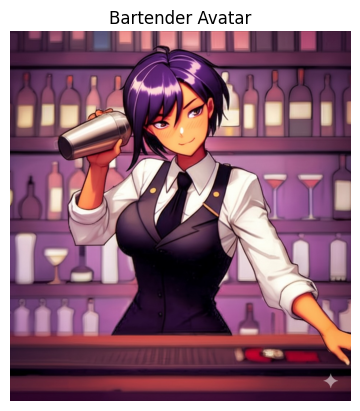

Avatar saved to bartender_avatar.jpg


In [19]:
use_default_avatar = True

# Default avatar URL
default_avatar_url = "https://github.com/gen-ai-capstone-project-bartender-agent/MOK-5-ha/blob/main/assets/bartender_avatar_ai_studio.jpeg?raw=true"

if use_default_avatar:
    # Download default avatar
    try:
        response = requests.get(default_avatar_url)
        if response.status_code == 200:
            avatar_bytes = response.content
            avatar_image = Image.open(io.BytesIO(avatar_bytes))
            print("Using default avatar image")
        else:
            print(f"Failed to download default avatar. Status code: {response.status_code}")
            # Create a blank avatar as fallback
            avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))
    except Exception as e:
        print(f"Error using default avatar: {e}")
        # Create a blank avatar as fallback
        avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))
else:
    # Ask user to upload an avatar
    print("Please upload an avatar image:")
    # uploaded = files.upload()
    # if uploaded:
    #     avatar_key = next(iter(uploaded))
    #     avatar_bytes = uploaded[avatar_key]
    #     avatar_image = Image.open(io.BytesIO(avatar_bytes))
    #     print(f"Uploaded avatar: {avatar_key}")
    # else:
    print("No avatar uploaded, using default")
    # Create a blank avatar as fallback
    avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))

# Display the avatar
plt.imshow(avatar_image)
plt.axis('off')
plt.title("Bartender Avatar")
plt.show()

# Save avatar for use in Gradio
avatar_path = "bartender_avatar.jpg"
avatar_image.save(avatar_path)
print(f"Avatar saved to {avatar_path}")

In [20]:
def handle_gradio_input(
    user_input: str,
    session_history_state: List[Dict[str, str]],
    session_order_state: List[Dict[str, float]]
) -> Tuple[str, List[Dict[str, str]], List[Dict[str, str]], List[Dict[str, float]], Any]:
    """
    Gradio callback: Takes input/state, calls logic & TTS, returns updates.
    """
    logger.info(f"Gradio input: '{user_input}'")
    logger.debug(f"Received session history state (len {len(session_history_state)}): {session_history_state}")
    logger.debug(f"Received session order state (len {len(session_order_state)}): {session_order_state}")

    # Call text processing logic first
    response_text, updated_history, updated_history_for_gradio, updated_order, _ = process_order(
        user_input,
        session_history_state,
        session_order_state
    )

    # --- Get Voice Audio ---
    audio_data = None # Default to None
    # Check if there is a non-empty response text to synthesize
    if response_text and response_text.strip():
         audio_data = get_voice_audio(response_text) # Call the imported function
         if audio_data is None:
             logger.warning("Failed to get audio data from get_voice_audio.")
             # Optional: Add indication to user? E.g., append "[Audio failed]" to response_text
    else:
        logger.info("No response text generated, skipping TTS.")
    # --- End Get Voice Audio ---

    # Return updates including audio data (which might be None)
    return "", updated_history, updated_history, updated_order, audio_data

In [21]:
def clear_chat_state() -> Tuple[List, List, List, None]:
    """Clears UI/session state including audio."""
    logger.info("Clear button clicked - Resetting session state.")
    # Return empty lists for Chatbot/history/order, and None for the audio component
    return [], [], [], None

# Launch the Gradio Interface

In [22]:
def launch_bartender_interface():
    theme = gr.themes.Citrus()

    with gr.Blocks(theme=synthwave_theme) as demo:
        gr.Markdown("# MOK 5-ha - Meet Maya the Bartender 🍸👋")
        gr.Markdown("Welcome to MOK 5-ha! I'm Maya, your virtual bartender. Ask me for a drink or check your order.")

        # --- Define Session State Variables ---
        history_state = gr.State([])
        order_state = gr.State([])

        # --- Restructured Main Row with 2 Columns (Equal Scaling) ---
        with gr.Row():

            # --- Column 1: Avatar Image ---
            # Scale is relative to other columns in the same row
            with gr.Column(scale=1, min_width=200): # Keep scale=1
                gr.Image(
                    value=avatar_path,  # Use the saved avatar path
                    label="Bartender Avatar",
                    show_label=False,
                    interactive=False,
                    height=600, # Adjust as desired
                    elem_classes=["avatar-image"]
                )

            # --- Column 2: Chat Interface ---
            with gr.Column(scale=1): # <-- Changed scale from 3 to 1
                chatbot_display = gr.Chatbot(
                    [],
                    elem_id="chatbot",
                    label="Conversation",
                    height=489, # Keep or adjust height for rectangular shape
                    type="messages"
                )
                agent_audio_output = gr.Audio(
                    label="Agent Voice",
                    autoplay=True,
                    streaming=False,
                    format="wav",
                    show_label=True,
                    interactive=False
                )
                msg_input = gr.Textbox(
                    label="Your Order / Message",
                    placeholder="What can I get for you? (e.g., 'I'd like a Margarita', 'Show my order')"
                )
                with gr.Row():
                    clear_btn = gr.Button("Clear Conversation")
                    submit_btn = gr.Button("Send", variant="primary")

        # --- Event Handlers (Remain the same) ---
        submit_inputs = [msg_input, history_state, order_state]
        submit_outputs = [msg_input, chatbot_display, history_state, order_state, agent_audio_output]
        msg_input.submit(handle_gradio_input, submit_inputs, submit_outputs)
        submit_btn.click(handle_gradio_input, submit_inputs, submit_outputs)

        clear_outputs = [chatbot_display, history_state, order_state, agent_audio_output]
        clear_btn.click(clear_chat_state, None, clear_outputs)

    # Launch the interface
    demo.launch(debug=True, share=True)  # share=True to make it accessible via a public URL

# Run the Bartending Agent 🍸👋

In [ ]:
# Launch the interface when this cell is executed
launch_bartender_interface()

2025-04-20 01:30:41,831 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
2025-04-20 01:30:42,061 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-04-20 01:30:42,095 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


2025-04-20 01:30:42,357 - httpx - INFO - HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://176c8dc8bf7a17e4dd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


2025-04-20 01:30:44,298 - httpx - INFO - HTTP Request: HEAD https://176c8dc8bf7a17e4dd.gradio.live "HTTP/1.1 200 OK"


2025-04-20 01:31:01,873 - __main__ - INFO - Gradio input: 'Hi Maya! 2 IPA beers please'
2025-04-20 01:31:01,877 - __main__ - INFO - Processing user input for session: Hi Maya! 2 IPA beers please
/Users/pretermodernist/MOK-5-ha/.venv/lib/python3.13/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
2025-04-20 01:31:08,000 - __main__ - INFO - LLM requested tool calls: [{'name': 'add_to_order', 'args': {'quantity': 2.0, 'item_name': 'IPA'}, 'id': '228e8b65-05bf-4378-b109-a59af34a2f67', 'type': 'tool_call'}]
2025-04-20 01:31:08,005 - __main__ - INFO - Tool: Added 2 x 'IPA' (no modifiers) to order and history.
2025-04-20 01:31:08,006 - __main__ - INFO - Executed tool 'add_to_order' with args {'quantity': 2.0, 'item_name': 'IPA'}. Output: Successfully added 2 x IPA (no modifiers) to the order.
2025-04-20 01:31:08,007 - __main__ - INFO - Sending tool re

Using Gemini model: gemini-2.5-flash-preview-04-17


2025-04-20 01:32:26,948 - __main__ - INFO - Original response: Great! Are you ready to settle up, or would you like to keep the tab open for a bit?
2025-04-20 01:32:26,949 - __main__ - INFO - RAG-enhanced response: Well, hopefully, the drinks sound even better!
2025-04-20 01:32:26,951 - __main__ - INFO - Final agent response: Well, hopefully, the drinks sound even better!
2025-04-20 01:32:26,953 - __main__ - INFO - Requesting TTS from Cartesia (Voice ID: 6f84f4b8-58a2-430c-8c79-688dad597532) for: 'Well, hopefully, the drinks sound even better!...'
2025-04-20 01:32:27,358 - httpx - INFO - HTTP Request: POST https://api.cartesia.ai/tts/bytes "HTTP/1.1 200 OK"
2025-04-20 01:32:28,169 - __main__ - INFO - Received 219170 bytes of WAV audio data from Cartesia.
2025-04-20 01:32:39,099 - __main__ - INFO - Gradio input: 'Can I add a 20% tip? '
2025-04-20 01:32:39,103 - __main__ - INFO - Processing user input for session: Can I add a 20% tip? 
2025-04-20 01:32:40,036 - __main__ - INFO - LLM requ

Using Gemini model: gemini-2.5-flash-preview-04-17


2025-04-20 01:32:45,075 - __main__ - INFO - Original response: Absolutely! Adding a 20% tip for you. Your new total is $14.40. Thank you so much, I really appreciate it! Are you ready to settle up?
2025-04-20 01:32:45,075 - __main__ - INFO - RAG-enhanced response: Why, adding a 20% tip would be wonderfully kind, thank you very much!
2025-04-20 01:32:45,076 - __main__ - INFO - Final agent response: Why, adding a 20% tip would be wonderfully kind, thank you very much!
2025-04-20 01:32:45,077 - __main__ - INFO - Requesting TTS from Cartesia (Voice ID: 6f84f4b8-58a2-430c-8c79-688dad597532) for: 'Why, adding a 20% tip would be wonderfully kind, t...'
2025-04-20 01:32:45,482 - httpx - INFO - HTTP Request: POST https://api.cartesia.ai/tts/bytes "HTTP/1.1 200 OK"
2025-04-20 01:32:47,028 - __main__ - INFO - Received 384126 bytes of WAV audio data from Cartesia.
2025-04-20 01:33:09,895 - __main__ - INFO - Gradio input: 'Alright. What do I owe you now?'
2025-04-20 01:33:09,896 - __main__ - INFO -